<a href="https://colab.research.google.com/github/shahbhavya7/cattle_model/blob/main/Notebooks/cattle_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.mstats import winsorize

In [12]:
ds=pd.read_excel('../Data/Raw/cattle.xlsx')

In [13]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   AnimalNo              517 non-null    int64  
 1   WHHeightAtWither      517 non-null    int64  
 2   Rumpheight            517 non-null    int64  
 3   BLBodylengthcm        517 non-null    int64  
 4   Scapuloischiallength  517 non-null    int64  
 5   SternumHeight         517 non-null    int64  
 6   ChestDepth            517 non-null    int64  
 7   RumpWidth             517 non-null    int64  
 8   RumpLength            517 non-null    int64  
 9   HeartGirth            517 non-null    int64  
 10  AbdGirth              517 non-null    int64  
 11  CannonBoneDiameter    517 non-null    float64
 12  HockBoneDiameter      517 non-null    int64  
 13  ActualBodyWeight      517 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 56.7 KB


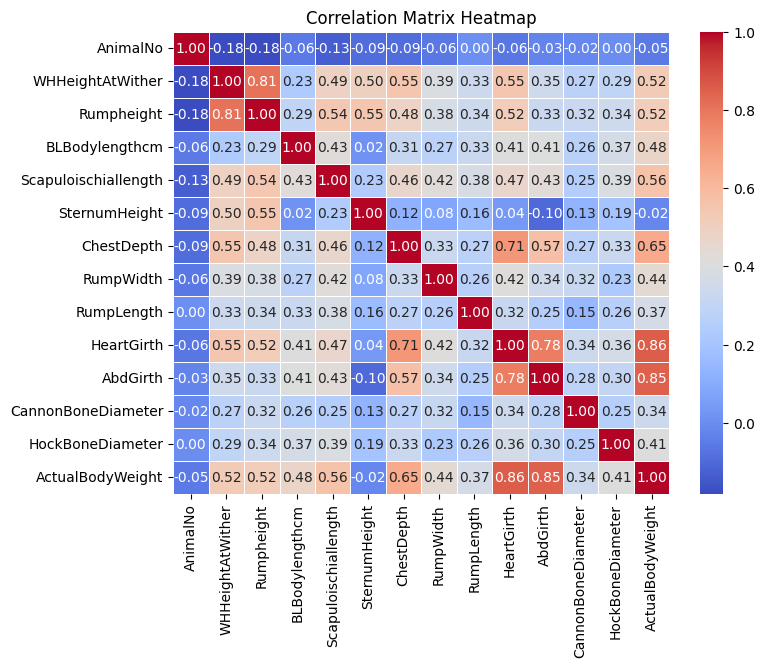

In [14]:
correlation_matrix=ds.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

In [15]:
## Highlt correlated features with correlation > 0.7
strongest_corr = correlation_matrix.abs().unstack().sort_values(ascending=False)
print("\nStrongest Correlations:")
print(strongest_corr[strongest_corr < 1].head(10))


Strongest Correlations:
ActualBodyWeight  HeartGirth          0.859868
HeartGirth        ActualBodyWeight    0.859868
AbdGirth          ActualBodyWeight    0.851238
ActualBodyWeight  AbdGirth            0.851238
WHHeightAtWither  Rumpheight          0.808738
Rumpheight        WHHeightAtWither    0.808738
AbdGirth          HeartGirth          0.778769
HeartGirth        AbdGirth            0.778769
ChestDepth        HeartGirth          0.711864
HeartGirth        ChestDepth          0.711864
dtype: float64


In [16]:
# features highly correlated with target variable 'ActualBodyWeight'
target_corr = correlation_matrix['ActualBodyWeight'].abs().sort_values(ascending=False)
print("\nFeatures highly correlated with 'ActualBodyWeight':")
print(target_corr[target_corr < 1].head(10))



Features highly correlated with 'ActualBodyWeight':
HeartGirth              0.859868
AbdGirth                0.851238
ChestDepth              0.651687
Scapuloischiallength    0.563804
WHHeightAtWither        0.524599
Rumpheight              0.516874
BLBodylengthcm          0.477655
RumpWidth               0.439753
HockBoneDiameter        0.410467
RumpLength              0.368583
Name: ActualBodyWeight, dtype: float64


In [17]:
correlated_features = ['HeartGirth', 'AbdGirth', 'ChestDepth'] 

In [18]:
# dropping uncorrelated features
ds = ds[correlated_features + ['ActualBodyWeight']]


In [19]:
ds.columns

Index(['HeartGirth', 'AbdGirth', 'ChestDepth', 'ActualBodyWeight'], dtype='object')

In [20]:
ds.isnull().sum()

HeartGirth          0
AbdGirth            0
ChestDepth          0
ActualBodyWeight    0
dtype: int64

In [21]:
ds.shape

(517, 4)

In [9]:
ds.duplicated().sum()

0

In [23]:
X=ds.iloc[:,:-1]
y=ds.iloc[:,-1]

In [24]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

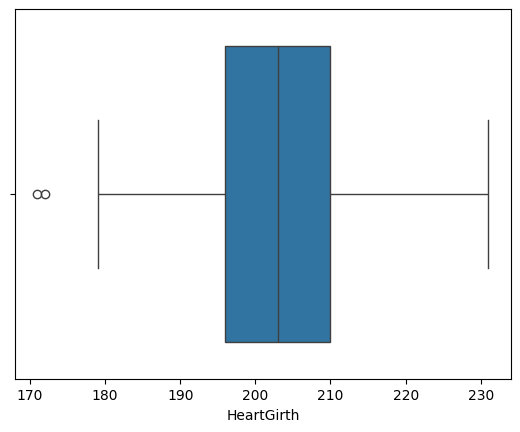

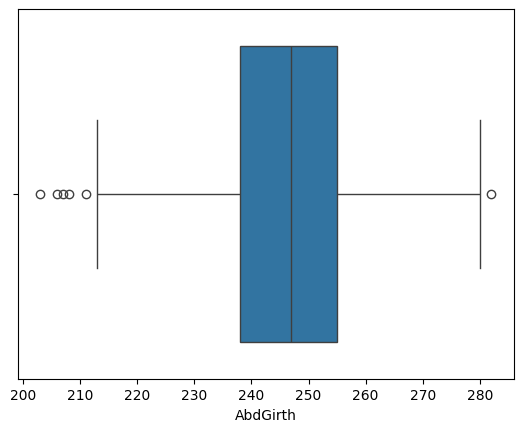

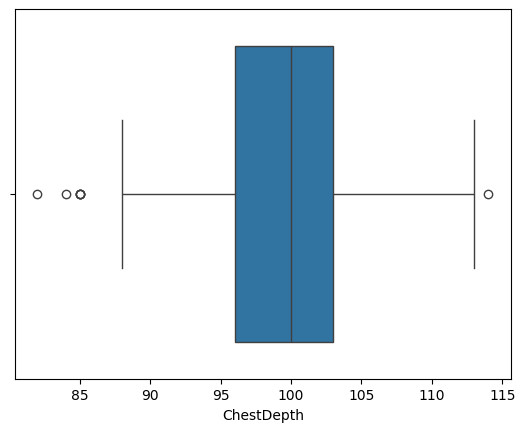

In [25]:
for col in X_train.columns:
  sns.boxplot(data=X_train,x=col)
  plt.show()
  print('\n')


In [26]:
def get_limits(X,lower=0.02,upper=0.98):
  limits={col:(np.quantile(X[col],lower),(np.quantile(X[col],upper))) for col in X.columns}
  return limits

In [27]:
def apply_limits(X,limits):
  X_win=X.copy()
  for col in X.columns:
    lower,upper=limits[col]
    X_win[col]=np.clip(X[col],lower,upper)
  return X_win

In [28]:
def get_manual_cap_limits(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR
    return lower_limit, upper_limit

In [29]:
from sklearn.base import BaseEstimator, TransformerMixin
class Winsorizer(BaseEstimator,TransformerMixin):
  def __init__(self,lower=0.02,upper=0.98):
    self.lower=lower
    self.upper=upper
    self.limits={}

  def fit(self,X,y=None):
    self.limits=get_limits(X,self.lower,self.upper)
    return self

  def transform(self,X):
    return apply_limits(X,self.limits)

In [30]:
class Manual_capper(BaseEstimator,TransformerMixin):
  def __init__(self,column):
    self.column=column
    self.limits=(None,None)

  def fit(self,X,y=None):
    self.limits=get_manual_cap_limits(X,self.column)
    return self

  def transform(self,X):
    X_new=X.copy()
    lower,upper=self.limits
    X_new[self.column]=np.clip(X_new[self.column],lower,upper)
    return X_new

In [31]:
from sklearn.base import BaseEstimator, TransformerMixin

class FeatureEngineer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_new = X.copy()
        X_new['Rump_Wither_Ratio'] = X_new['Rumpheight'] / X_new['WHHeightAtWither']
        X_new['Length_Wither_Ratio'] = X_new['BLBodylengthcm'] / X_new['WHHeightAtWither']
        X_new = X_new.drop(columns=['Rumpheight','WHHeightAtWither','BLBodylengthcm'])
        return X_new

In [32]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def evaluate_regression(y_test, y_pred):
    # Calculate errors
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mean_y = np.mean(y_test)

    # Percentages
    rmse_percent = (rmse / mean_y) * 100
    mae_percent = (mae / mean_y) * 100

    # Quality assessment (combined RMSE% and R²)
    if rmse_percent < 5 and r2 > 0.85:
        quality = "Excellent"
    elif rmse_percent < 10 and r2 > 0.75:
        quality = "Good"
    elif rmse_percent < 15 and r2 > 0.6:
        quality = "Acceptable"
    else:
        quality = "Poor"

    # Print results
    print(f"RMSE: {rmse:.2f} kg ({rmse_percent:.1f}% of mean weight)")
    print(f"MAE: {mae:.2f} kg ({mae_percent:.1f}% of mean weight)")
    print(f"R²: {r2:.3f}")
    print(f"Model Quality: {quality}")

    return rmse, mae, r2, quality


In [34]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge,Lasso ,LinearRegression,ElasticNet
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

base_pipeline = Pipeline([
    ('winsor', Winsorizer()),
    ('scaler', StandardScaler()),
    ('model',ElasticNet())
])

base_pipeline.fit(X_train, y_train)
y_pred = base_pipeline.predict(X_test)

In [35]:
evaluate_regression(y_test, y_pred)

RMSE: 39.44 kg (6.6% of mean weight)
MAE: 29.67 kg (5.0% of mean weight)
R²: 0.789
Model Quality: Good


(39.43943216975565, 29.671102146486646, 0.7890551150098893, 'Good')

In [37]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
import numpy as np

models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'ElasticNet': ElasticNet(),
    'RandomForest': RandomForestRegressor(),
    'XGBoost': XGBRegressor()
}

for name, model in models.items():
    pipeline = Pipeline([
        ('winsor', Winsorizer()),
        ('scaler', StandardScaler()),
        ('model',model)
    ])
    scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
    rmse = -np.mean(scores)
    rmse_percent = (rmse / y_train.mean()) * 100
    print(f"{name}: CV RMSE = {rmse:.2f} kg ({rmse_percent:.1f}% of mean weight)")



LinearRegression: CV RMSE = 32.92 kg (5.5% of mean weight)
Ridge: CV RMSE = 32.92 kg (5.5% of mean weight)
Lasso: CV RMSE = 32.98 kg (5.5% of mean weight)
ElasticNet: CV RMSE = 35.97 kg (6.0% of mean weight)
RandomForest: CV RMSE = 36.42 kg (6.0% of mean weight)
XGBoost: CV RMSE = 42.54 kg (7.0% of mean weight)


In [39]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
import numpy as np

# Define your preprocessing pipeline template
def create_pipeline(model, scale=True):
    steps = [
        ('winsor', Winsorizer()),
    ]
    if scale:
        steps.append(('scaler', StandardScaler()))
    steps.append(('model', model))
    return Pipeline(steps)

# Linear models
linear_models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'ElasticNet': ElasticNet()
}

param_grids_linear = {
    'LinearRegression': {},  # no hyperparameters
    'Ridge': {'model__alpha': [0.01, 0.1, 1.0, 10.0]},
    'Lasso': {'model__alpha': [0.01, 0.1, 1.0, 10.0]},
    'ElasticNet': {'model__alpha': [0.01,0.1,1.0], 'model__l1_ratio':[0.2,0.5,0.8]}
}

print("=== Linear Models (GridSearchCV) ===")
for name, model in linear_models.items():
    pipeline = create_pipeline(model, scale=True)
    grid = GridSearchCV(pipeline, param_grid=param_grids_linear[name],
                        cv=5, scoring='neg_root_mean_squared_error')
    grid.fit(X_train, y_train)

    best_rmse = -grid.best_score_
    best_rmse_percent = (best_rmse / y_train.mean()) * 100
    print(f"{name}: Best CV RMSE = {best_rmse:.2f} kg ({best_rmse_percent:.1f}% of mean weight), Best params: {grid.best_params_}")

# Tree/boosting models
tree_models = {
    'RandomForest': RandomForestRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42)
}

param_dists_tree = {
    'RandomForest': {
        'model__n_estimators': [100, 200, 500],
        'model__max_depth': [None, 5, 10, 20],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4]
    },
    'XGBoost': {
        'model__n_estimators': [100, 200, 500],
        'model__learning_rate': [0.01, 0.05, 0.1],
        'model__max_depth': [3, 5, 7, 10],
        'model__colsample_bytree': [0.6, 0.8, 1.0]
    }
}

print("\n=== Tree/Boosting Models (RandomizedSearchCV) ===")
for name, model in tree_models.items():
    pipeline = create_pipeline(model, scale=False)  # trees don't need scaling
    random_search = RandomizedSearchCV(
        pipeline, param_distributions=param_dists_tree[name],
        n_iter=20, cv=5, scoring='neg_root_mean_squared_error', random_state=42
    )
    random_search.fit(X_train, y_train)

    best_rmse = -random_search.best_score_
    best_rmse_percent = (best_rmse / y_train.mean()) * 100
    print(f"{name}: Best CV RMSE = {best_rmse:.2f} kg ({best_rmse_percent:.1f}% of mean weight), Best params: {random_search.best_params_}")


=== Linear Models (GridSearchCV) ===
LinearRegression: Best CV RMSE = 32.92 kg (5.5% of mean weight), Best params: {}
Ridge: Best CV RMSE = 32.92 kg (5.5% of mean weight), Best params: {'model__alpha': 1.0}
Lasso: Best CV RMSE = 32.92 kg (5.5% of mean weight), Best params: {'model__alpha': 0.01}
ElasticNet: Best CV RMSE = 32.92 kg (5.5% of mean weight), Best params: {'model__alpha': 0.01, 'model__l1_ratio': 0.2}

=== Tree/Boosting Models (RandomizedSearchCV) ===
RandomForest: Best CV RMSE = 33.62 kg (5.6% of mean weight), Best params: {'model__n_estimators': 100, 'model__min_samples_split': 2, 'model__min_samples_leaf': 4, 'model__max_depth': 5}
XGBoost: Best CV RMSE = 35.56 kg (5.9% of mean weight), Best params: {'model__n_estimators': 500, 'model__max_depth': 10, 'model__learning_rate': 0.01, 'model__colsample_bytree': 0.6}


In [25]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import numpy as np

# Fit pipelines once
pipeline_ridge = create_pipeline(Ridge(alpha=1.0), scale=True).fit(X_train, y_train)
pipeline_lasso = create_pipeline(Lasso(alpha=0.1), scale=True).fit(X_train, y_train)
pipeline_en = create_pipeline(ElasticNet(alpha=0.01, l1_ratio=0.2), scale=True).fit(X_train, y_train)

# Precompute out-of-fold predictions for weight optimization
kf = KFold(n_splits=5, shuffle=True, random_state=42)
oof_preds = []

for pipeline in [pipeline_ridge, pipeline_lasso, pipeline_en]:
    preds = np.zeros(len(X_train))
    for train_idx, val_idx in kf.split(X_train):
        pipeline.fit(X_train.iloc[train_idx], y_train.iloc[train_idx])
        preds[val_idx] = pipeline.predict(X_train.iloc[val_idx])
    oof_preds.append(preds)

oof_preds = np.array(oof_preds)  # shape: (3 models, n_samples)

# Fast weight search using coarse grid
weight_options = [0.0, 0.25, 0.5, 0.75, 1.0]
best_rmse = np.inf
best_weights = None

for w_ridge in weight_options:
    for w_lasso in weight_options:
        for w_en in weight_options:
            if w_ridge + w_lasso + w_en == 0:
                continue
            weights = np.array([w_ridge, w_lasso, w_en])
            weights = weights / weights.sum()
            ensemble_pred = np.dot(weights, oof_preds)
            rmse = np.sqrt(mean_squared_error(y_train, ensemble_pred))
            if rmse < best_rmse:
                best_rmse = rmse
                best_weights = weights

# Make final weighted predictions on test set
preds_test = (
    best_weights[0] * pipeline_ridge.predict(X_test) +
    best_weights[1] * pipeline_lasso.predict(X_test) +
    best_weights[2] * pipeline_en.predict(X_test)
)

rmse_test = np.sqrt(mean_squared_error(y_test, preds_test))
rmse_percent = (rmse_test / y_test.mean()) * 100

print(f"Best weights: Ridge={best_weights[0]:.2f}, Lasso={best_weights[1]:.2f}, ElasticNet={best_weights[2]:.2f}")
print(f"Weighted Ensemble RMSE: {rmse_test:.2f} kg ({rmse_percent:.1f}% of mean weight)")


Best weights: Ridge=0.00, Lasso=0.20, ElasticNet=0.80
Weighted Ensemble RMSE: 33.09 kg (5.5% of mean weight)


In [40]:
# training with best model
final_pipeline = create_pipeline(ElasticNet(alpha=0.01, l1_ratio=0.2), scale=True)
final_pipeline.fit(X_train, y_train)
final_preds = final_pipeline.predict(X_test)
evaluate_regression(y_test, final_preds)


RMSE: 35.13 kg (5.9% of mean weight)
MAE: 26.80 kg (4.5% of mean weight)
R²: 0.833
Model Quality: Good


(35.13497785769013, 26.804518001044375, 0.8325878166915041, 'Good')

In [26]:
# for col in X_train_win.columns:
#   sns.boxplot(data=X_train_win,x=col)
#   plt.show()
#   print('\n')

In [27]:
# skew_result = X_win.skew(numeric_only=True).to_dict()
# print(skew_result)

In [28]:
# skew_result = y_win.skew(numeric_only=True)
# print(skew_result)

RMSE: 30.04 kg (5.0% of mean weight)
MAE: 22.97 kg (3.8% of mean weight)
R²: 0.866
Model Quality: Good
(np.float64(30.039672370500533), 22.9675643106626, 0.866380202946881, 'Good')